<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Examen_proyecto_UT1%2C_UT2_y_UT3_MotoresNASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Examen / Proyecto UT1, UT2 y UT3**

# ***Jesús Roque Armas Martín - CEIABD***

Importo las librerías necesarias

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import random
import warnings
import sklearn
import sklearn.externals
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

warnings.filterwarnings('ignore')

Defino los nombres de las características

In [2]:
nombres_comunes  = ['numero_unidad', 'ciclo_temporal']
nombres_caracteristicas = ['carac_1', 'carac_2', 'carac_3']
nombres_sensor   = ['sensor_{}'.format(i+1) for i in range(0,21)]
nombres_columnas = nombres_comunes + nombres_caracteristicas + nombres_sensor

Importo los ficheros de train, test y validation, guardados anteriormente en GitHub



In [3]:
dstrain  = pd.read_csv('https://raw.githubusercontent.com/roquearmas/IABD_DATA/main/train_FD004.txt',sep='\s+',header=None,index_col=False,names=nombres_columnas)
dstest   = pd.read_csv('https://raw.githubusercontent.com/roquearmas/IABD_DATA/main/test_FD004.txt' ,sep='\s+',header=None,index_col=False,names=nombres_columnas)
y_valid  = pd.read_csv('https://raw.githubusercontent.com/roquearmas/IABD_DATA/main/RUL_FD004.txt'  ,sep='\s+',header=None,index_col=False,names=['RUL'])


Tamaños de los datasets, porcentaje de test con respecto a train

In [4]:
print('Tamaño del dataset de entrenamiento : ',dstrain.shape)
print('Tamaño del dataset de test :          ',dstest.shape)
porcentaje_test = len(dstest)/(len(dstest)+len(dstrain))
print('Porcentaje del dataset de test :     ',f"{porcentaje_test:.3%}")

Tamaño del dataset de entrenamiento :  (61249, 26)
Tamaño del dataset de test :           (41214, 26)
Porcentaje del dataset de test :      40.223%


Método para añadir la columna ***RUL*** (es la variable que va a ser nuestra y)

El valor ***RUL*** se corresponde con el número de ciclos que le queda a cada motor, antes de que falle.

Cuando el modelo esté entrenado, nos dirá, en un momento determinado de la vida del motor, cuántos ciclos útiles le quedan.


In [5]:
def add_RUL(df):
  train_agrupado_por_unidad = df.groupby(by='numero_unidad')
  ciclo_temporal_max = train_agrupado_por_unidad['ciclo_temporal'].max()
  mezcla = df.merge(ciclo_temporal_max.to_frame(name='ciclo_temporal_max'), left_on='numero_unidad',right_index=True)
  mezcla['RUL'] = mezcla['ciclo_temporal_max'] - mezcla['ciclo_temporal']
  mezcla = mezcla.drop('ciclo_temporal_max', axis=1)
  return mezcla


In [6]:
dstrain = add_RUL(dstrain)
dstest=add_RUL(dstest)
dstest[['numero_unidad','RUL']]


,numero_unidad,RUL
0,1,229
1,1,228
2,1,227
3,1,226
4,1,225
...,...,...
41209,248,4
41210,248,3
41211,248,2
41212,248,1


Análisis de los datos con RUL (y). Queremos obtener el número máximo de ciclos que aguanta un motor, hasta que falla.

In [7]:
maxrul = dstrain.groupby('numero_unidad').max().reset_index()
maxrul

,numero_unidad,ciclo_temporal,carac_1,carac_2,carac_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,321,42.0079,0.8420,100.0,518.67,643.50,1603.28,1422.53,14.62,...,2388.87,8184.95,10.9141,0.03,397,2388,100.0,39.58,23.8649,320
1,2,299,42.0079,0.8420,100.0,518.67,643.88,1599.51,1434.23,14.62,...,2388.37,8143.04,11.0337,0.03,396,2388,100.0,39.15,23.4692,298
2,3,307,42.0079,0.8420,100.0,518.67,643.45,1605.04,1425.73,14.62,...,2388.91,8188.39,10.8552,0.03,396,2388,100.0,39.51,23.7657,306
3,4,274,42.0080,0.8419,100.0,518.67,644.07,1605.47,1432.75,14.62,...,2389.42,8210.13,11.0113,0.03,397,2388,100.0,39.11,23.4354,273
4,5,193,42.0072,0.8418,100.0,518.67,643.76,1607.29,1430.47,14.62,...,2389.46,8187.83,11.0254,0.03,398,2388,100.0,38.96,23.4060,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,245,205,42.0080,0.8418,100.0,518.67,643.85,1605.51,1430.77,14.62,...,2388.45,8143.10,11.0135,0.03,397,2388,100.0,39.17,23.5146,204
245,246,161,42.0078,0.8419,100.0,518.67,643.94,1605.65,1426.86,14.62,...,2388.40,8127.50,11.0271,0.03,396,2388,100.0,38.98,23.3750,160
246,247,211,42.0077,0.8420,100.0,518.67,643.56,1607.46,1425.60,14.62,...,2388.76,8181.85,10.9206,0.03,397,2388,100.0,39.44,23.8748,210
247,248,184,42.0076,0.8420,100.0,518.67,643.95,1607.37,1430.34,14.62,...,2388.38,8135.69,11.0088,0.03,397,2388,100.0,38.96,23.4652,183


Nos desembarazamos de las columnas no elegidas en el proyecto anterior.

In [8]:
X_motores = dstrain.drop(['carac_1','carac_2','carac_3','sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10'], axis=1)
X_motores =X_motores.drop(['sensor_12','sensor_13','sensor_15','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21'], axis=1)
dstest =dstest.drop(['carac_1','carac_2','carac_3','sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10'], axis=1)
dstest =dstest.drop(['sensor_12','sensor_13','sensor_15','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21'], axis=1)
X_motores

,numero_unidad,ciclo_temporal,sensor_11,sensor_14,sensor_16,RUL
0,1,1,41.69,8074.83,0.02,320
1,1,2,43.94,8046.13,0.02,319
2,1,3,41.66,8066.62,0.02,318
3,1,4,41.68,8076.05,0.02,317
4,1,5,36.48,7865.80,0.02,316
...,...,...,...,...,...,...
61244,249,251,46.08,8185.69,0.03,4
61245,249,252,48.04,8185.47,0.03,3
61246,249,253,48.24,8193.94,0.03,2
61247,249,254,42.53,8125.64,0.02,1


Entreno el modelo LinearRegression, para predecir los valores

In [12]:
y_motores = dstrain['RUL']
# Creamos el modelo
linear = LinearRegression()

# Entrenamos el modelo
linear.fit(X_motores, y_motores)

pred = linear.predict(dstest)

Obtenemos la calidad de los resultados obtenidos, mediante las métricas MSE, MAE y MAPE

In [13]:
# Evaluación
y_test = dstest['RUL']
print('MSE : %.2f' % metrics.mean_squared_error(pred,y_test))
print('MAE : %.2f' % metrics.mean_absolute_error (pred,y_test))
print('MAPE: %.2f' % metrics.mean_absolute_percentage_error(pred, y_test))

MSE : 0.00
MAE : 0.00
MAPE: 0.01


Aplico KNeighborsRegressor

In [15]:
MSE_minimo=200
MAE_minimo=10
MAPE_minimo=2
for k in range(1,15):
  w = "distance"

  # 1. elegir regresor
  from sklearn.neighbors import KNeighborsRegressor
  # 2. instanciar el modelo
  regr = KNeighborsRegressor(k, weights=w)
  # 3. entrenamiento con los datos
  regr.fit(X_motores, y_motores)
  # 4. predicción con nuevos datos
  pred = regr.predict(dstest)
  if metrics.mean_squared_error(pred,y_test)<MSE_minimo:
    MSE_minimo=metrics.mean_squared_error(pred,y_test)
    print ('MSE minimo con %i vecinos, %2f' %(k,MSE_minimo))
  if metrics.mean_absolute_error (pred,y_test)<MAE_minimo:
    MAE_minimo=metrics.mean_absolute_error (pred,y_test)
    print ('MAE minimo con %i vecinos, %2f' %(k,MAE_minimo))
  if metrics.mean_absolute_percentage_error(pred, y_test)<MAPE_minimo:
    MAPE_minimo=metrics.mean_absolute_percentage_error(pred, y_test)
    print ('MAPE minimo con %i vecinos, %2f' %(k,MAPE_minimo))


MSE minimo con 1 vecinos, 165.299316
MAE minimo con 1 vecinos, 8.241957
MSE minimo con 2 vecinos, 159.623258
MAE minimo con 2 vecinos, 7.865766
MSE minimo con 3 vecinos, 157.079231
MAE minimo con 3 vecinos, 7.702747
MSE minimo con 4 vecinos, 154.975150
MAE minimo con 4 vecinos, 7.588187
MAPE minimo con 4 vecinos, 0.140817
MSE minimo con 5 vecinos, 153.283576
MAE minimo con 5 vecinos, 7.495462
MAPE minimo con 5 vecinos, 0.137550
MSE minimo con 6 vecinos, 152.094541
MAE minimo con 6 vecinos, 7.428487
MAPE minimo con 6 vecinos, 0.135503
MSE minimo con 7 vecinos, 151.688370
MAE minimo con 7 vecinos, 7.388874
MAPE minimo con 7 vecinos, 0.134367
MSE minimo con 8 vecinos, 151.216185
MAE minimo con 8 vecinos, 7.354848
MAPE minimo con 8 vecinos, 0.133600
MSE minimo con 9 vecinos, 150.917607
MAE minimo con 9 vecinos, 7.330046
MAPE minimo con 9 vecinos, 0.133207
MSE minimo con 10 vecinos, 150.694632
MAE minimo con 10 vecinos, 7.308128
MAPE minimo con 10 vecinos, 0.132625
MAE minimo con 11 vecinos

Obtengo valores minimos para k=12 y w='distance'

In [16]:
k=12
w = "distance"

# 1. elegir regresor
from sklearn.neighbors import KNeighborsRegressor
# 2. instanciar el modelo
regr = KNeighborsRegressor(k, weights=w)
# 3. entrenamiento con los datos
regr.fit(X_motores, y_motores)
# 4. predicción con nuevos datos
pred = regr.predict(dstest)
MSE=metrics.mean_squared_error(pred,y_test)
print ('MSE : %2f' %(MSE))
MAE=metrics.mean_absolute_error (pred,y_test)
print ('MAE : %2f' %(MAE))
MAPE=metrics.mean_absolute_percentage_error(pred, y_test)
print ('MAPE: %2f' %(MAPE))


MSE : 150.855168
MAE : 7.288408
MAPE: 0.132224


Entreno el modelo de árbol de decisiones


In [17]:
dec_tree = DecisionTreeRegressor()
# Entrenar el modelo
dec_tree.fit(X_motores, y_motores)
pred = dec_tree.predict(dstest)
MSE=metrics.mean_squared_error(pred,y_test)
print ('MSE : %2f' %(MSE))
MAE=metrics.mean_absolute_error (pred,y_test)
print ('MAE : %2f' %(MAE))
MAPE=metrics.mean_absolute_percentage_error(pred, y_test)
print ('MAPE: %2f' %(MAPE))



MSE : 0.000146
MAE : 0.000146
MAPE: 0.000000


Método para entrenar un modelo con cross validation, e inferir el número de splits óptimo, en los que se han de partir los datos para obtener mejores resultados.

In [43]:
def entrenar_CV(modelo):
  splits=[]
  acu_cv=[]
  mse_cv=[]
  mae_cv=[]
  mape_cv=[]
  mape_min=[120,1]
  s_inicio=2
  s_fin=101
  t_inicio=time.time()
  for i in range(s_inicio, s_fin):
    #Divide los datos en n_splits partes, de manera aleatoria (shuffle)
    if i%10 ==0:
      completado=((i-s_inicio)*100)/(s_fin-s_inicio)
      t_transcurrido=time.time()-t_inicio
      t_estimado = (t_transcurrido *100/completado ) - t_transcurrido
      print(i,' splits', completado  ,' % completado')
      print('tiempo transcurrido %2f' % (t_transcurrido/60))
      print('tiempo estimado %2f' % (t_estimado/60))
    cv = KFold(n_splits = i, shuffle = True)
    splits.append(i)

    scores = sklearn.model_selection.cross_val_score(modelo, X_motores, y_motores, cv=cv)
    mae  = sklearn.model_selection.cross_val_score(modelo, X_motores, y_motores,scoring="neg_mean_absolute_error", cv=cv)
    mse  = sklearn.model_selection.cross_val_score(modelo, X_motores, y_motores,scoring="neg_mean_squared_error", cv=cv)
    mape = sklearn.model_selection.cross_val_score(modelo, X_motores, y_motores,scoring="neg_mean_absolute_percentage_error", cv=cv)

    acu_cv.append(scores.mean())
    mse_cv.append(mse.mean())
    mae_cv.append(mae.mean())
    mape_cv.append(mape.mean())
    if mape.mean()<mape_min[1]:
      mape_min=[i,mape.mean()]
      print('mape minimo encontrado para %d splits' %i)

  return splits,acu_cv, mse_cv, mae_cv, mape_cv


In [24]:
def representa_entrenamiento_modelo(modelo,splits, acu_cv, mse_cv, mae_cv, mape_cv):
  if modelo==linear: #el modelo a entrenar es el LinearRegression
  #   print('Resultados de entrenamiento de LinearRegression')
    plt.title("Métricas de Error obtenidas del proceso de cross validation aplicado a LinearRegression",)
  elif modelo==dec_tree:
    plt.title("Métricas de Error obtenidas del proceso de cross validation aplicado a DecisionTreeRegressor",)
  else:
    #  print('Resultados de entrenamiento de KNNRegressor')
    plt.title("Métricas de Error obtenidas del proceso de cross validation aplicado a KNNRegressor")


  plt.xlabel("Splits")
  plt.plot(splits, acu_cv, color="red")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(splits, mse_cv   , color="green")
  plt.ylabel("MSE")
  plt.show()

  plt.plot(splits, mae_cv  , color="blue")
  plt.ylabel("MAE")
  plt.show()

  plt.plot(splits, mape_cv  , color="yellow")
  plt.ylabel("MAPE")
  plt.show()

Entreno los modelos LinearRegression y KNNRegressor, con cross validation y represento los valores, para elegir con cuántos splits deben entrenarse


mape minimo encontrado para 2 splits
10  splits 8.080808080808081  % completado
tiempo transcurrido 0.531427
tiempo estimado 6.044983
20  splits 18.181818181818183  % completado
tiempo transcurrido 2.522404
tiempo estimado 11.350819
30  splits 28.282828282828284  % completado
tiempo transcurrido 5.975091
tiempo estimado 15.151124
40  splits 38.38383838383838  % completado
tiempo transcurrido 10.977894
tiempo estimado 17.622408
50  splits 48.484848484848484  % completado
tiempo transcurrido 17.536968
tiempo estimado 18.633029
60  splits 58.58585858585859  % completado
tiempo transcurrido 25.829841
tiempo estimado 18.259026
70  splits 68.68686868686869  % completado
tiempo transcurrido 35.082033
tiempo estimado 15.993280
80  splits 78.78787878787878  % completado
tiempo transcurrido 45.762031
tiempo estimado 12.320547
90  splits 88.88888888888889  % completado
tiempo transcurrido 58.016943
tiempo estimado 7.252118
100  splits 98.98989898989899  % completado
tiempo transcurrido 71.670113


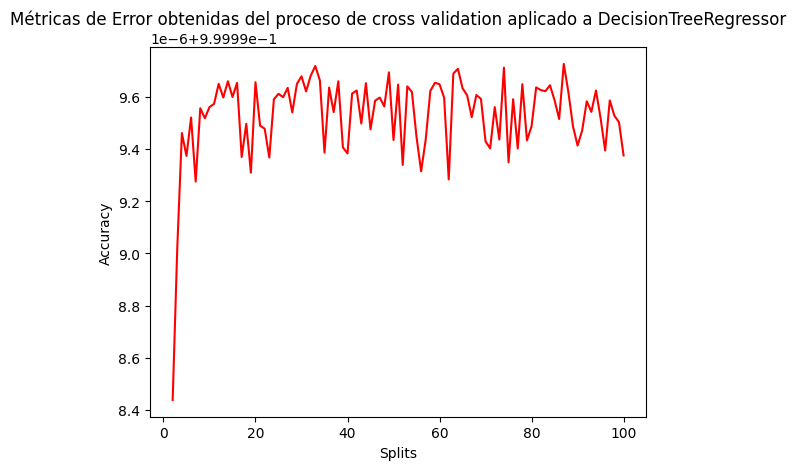

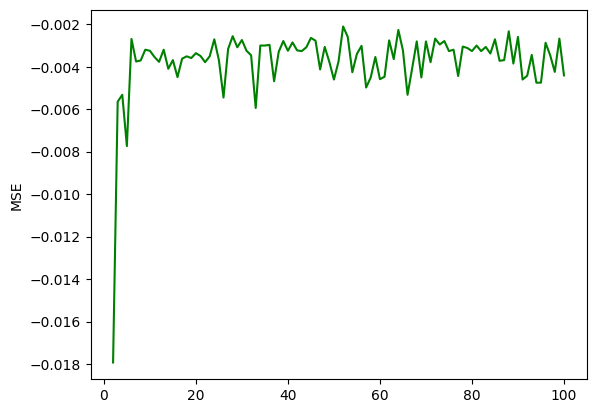

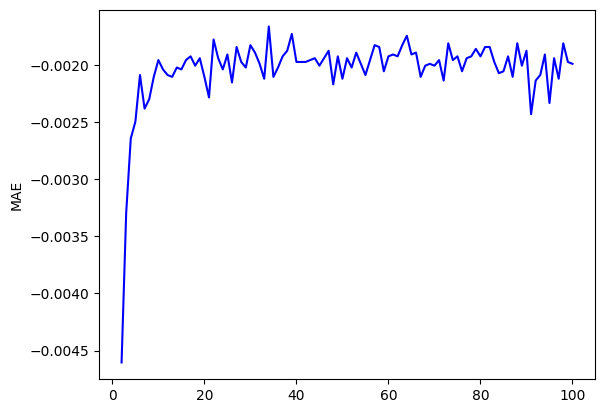

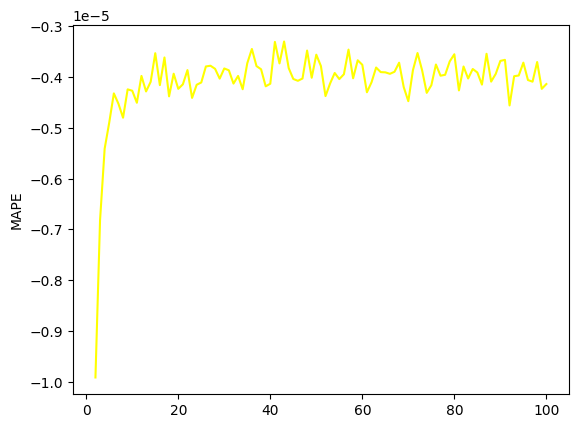

In [44]:
l_splits,l_acu_cv,l_mse_cv,l_mae_cv, l_mape_cv=entrenar_CV(dec_tree)
representa_entrenamiento_modelo(dec_tree,l_splits,l_acu_cv,l_mse_cv,l_mae_cv, l_mape_cv )



Método para entrenar modelos con cross validation y 2 splits

In [46]:
def cv_modelo (modelo):
  cv = KFold(n_splits = 2, shuffle = True)
  cv_mape=[]

  for cv_train, cv_test in cv.split(X_motores):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_motores.iloc[cv_train]
    cv_train_y = y_motores.iloc[cv_train]

    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_motores.iloc[cv_test])
    y_np=y_motores.iloc[cv_test].values
    mape = metrics.mean_absolute_percentage_error(  y_pred,y_np)
    cv_mape.append(mape)
  #guardo la media de los mapes, para cada split
  media_mape=sum(cv_mape)/len(cv_mape)

  #recorro los clasificadores y voy mostrando la precision por cada uno de ellos
  print ("MAE medio: = %.4f para 2 splits" %  (media_mape ))

Voy entrenando los modelos y obteniendo los valores de MAPE, para cada uno de ellos

In [49]:
cv_modelo (dec_tree)

MAE medio: = 0.0000 para 2 splits


representar valores de metricas de error en una gráfica

In [51]:
# Para exportar el modelo a un fichero
joblib.dump(dec_tree,'MotoresNasa.pkl')


['MotoresNasa.pkl']

Prueba de predicción del modelo, después de importado

In [52]:
model = joblib.load("MotoresNasa.pkl")
pred = model.predict(dstest)
y_test = dstest['RUL']
print('MSE : %.2f' % metrics.mean_squared_error(pred,y_test))
print('MAE : %.2f' % metrics.mean_absolute_error (pred,y_test))
print('MAPE: %.2f' % metrics.mean_absolute_percentage_error(pred, y_test))

MSE : 0.00
MAE : 0.00
MAPE: 0.00
